In [1]:
import torch
from torch_geometric.data import Data
import pandas as pd
from torch_geometric.nn import GCNConv
from sklearn.preprocessing import StandardScaler
from torch.optim import Adam
from torch.nn import MSELoss, L1Loss
import matplotlib.pyplot as plt
import util

In [2]:
df = pd.read_csv('../../Datasets/Lynx_Hare/data.csv', usecols=['DATE', 'HARE', 'LYNX'])
print(df)

# Create lagged features for one-step ahead prediction
df['HARE_lag1'] = df['HARE'].shift(1)
df['LYNX_lag1'] = df['LYNX'].shift(1)

df.dropna(inplace=True)

# Define features (x) and targets (y)
x = df[['HARE_lag1', 'LYNX_lag1']].values  # previous time step's data as input
y = df[['HARE', 'LYNX']].values  
print(x)

    DATE   HARE   LYNX
0   1845  19.58  30.09
1   1846  19.60  45.15
2   1847  19.61  49.15
3   1848  11.99  39.52
4   1849  28.04  21.23
..   ...    ...    ...
86  1931  19.52   8.31
87  1932  82.11  16.01
88  1933  89.76  24.82
89  1934  81.66  29.70
90  1935  15.76  35.40

[91 rows x 3 columns]
[[ 19.58  30.09]
 [ 19.6   45.15]
 [ 19.61  49.15]
 [ 11.99  39.52]
 [ 28.04  21.23]
 [ 58.     8.42]
 [ 74.6    5.56]
 [ 75.09   5.08]
 [ 88.48  10.17]
 [ 61.28  19.6 ]
 [ 74.67  32.91]
 [ 88.06  34.38]
 [ 68.51  29.59]
 [ 32.19  21.3 ]
 [ 12.64  13.69]
 [ 21.49   7.65]
 [ 30.35   4.08]
 [  2.18   4.09]
 [152.65  14.33]
 [148.36  38.22]
 [ 85.81  60.78]
 [ 41.41  70.77]
 [ 14.75  72.77]
 [  2.28  42.68]
 [  5.91  16.39]
 [  9.95   9.83]
 [ 10.44   5.8 ]
 [ 70.64   5.26]
 [ 50.12  18.91]
 [ 50.13  30.95]
 [101.25  31.18]
 [ 97.12  46.34]
 [ 86.51  45.77]
 [ 72.17  44.15]
 [ 38.32  36.33]
 [ 10.11  12.03]
 [  7.74  12.6 ]
 [  9.67  18.34]
 [ 43.12  35.14]
 [ 52.21  43.77]
 [134.85  65.69]
 [13

In [3]:
# Sequential split for training and testing
split_idx = int(len(x) * 0.8)
x_train, x_test = x[:split_idx], x[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]

scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

scaler = StandardScaler()
y_train = scaler.fit_transform(y_train)
y_test = scaler.transform(y_test)

# Convert to PyTorch tensors
x_train = torch.tensor(x_train, dtype=torch.float)
x_test = torch.tensor(x_test, dtype=torch.float)
y_train = torch.tensor(y_train, dtype=torch.float)
y_test = torch.tensor(y_test, dtype=torch.float)

In [4]:
edge_index = torch.tensor([[0], [1]], dtype=torch.long)  # Lynx -> Hare

data_train = Data(x=x_train, edge_index=edge_index)
data_test = Data(x=x_test, edge_index=edge_index)

In [5]:
# Model Implementation
class GNN(torch.nn.Module):
    def __init__(self):
        super(GNN, self).__init__()
        self.conv1 = GCNConv(2, 16)
        self.conv2 = GCNConv(16, 2)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = torch.relu(self.conv1(x, edge_index))
        x = self.conv2(x, edge_index)
        return x

In [6]:
model = GNN()
optimizer = Adam(model.parameters(), lr=0.01)
criterion = MSELoss()
mae_criterion = L1Loss()

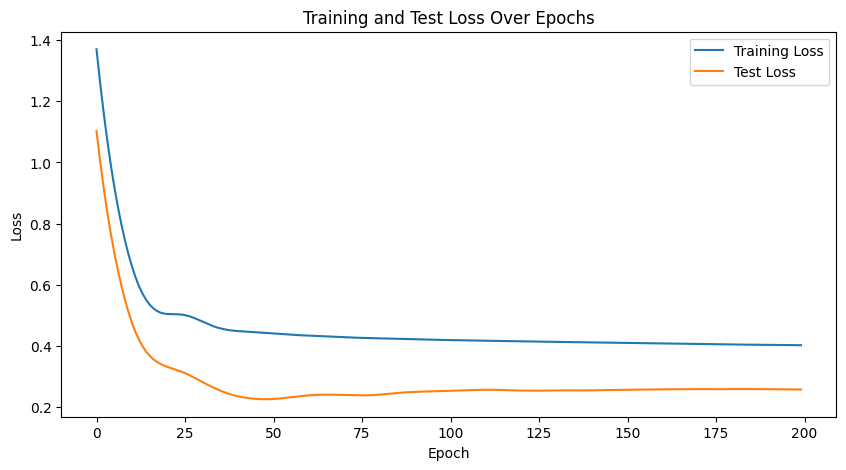

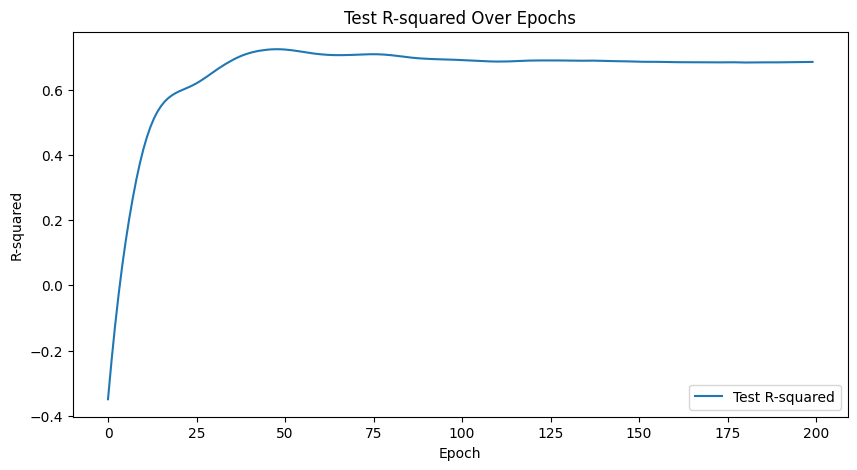

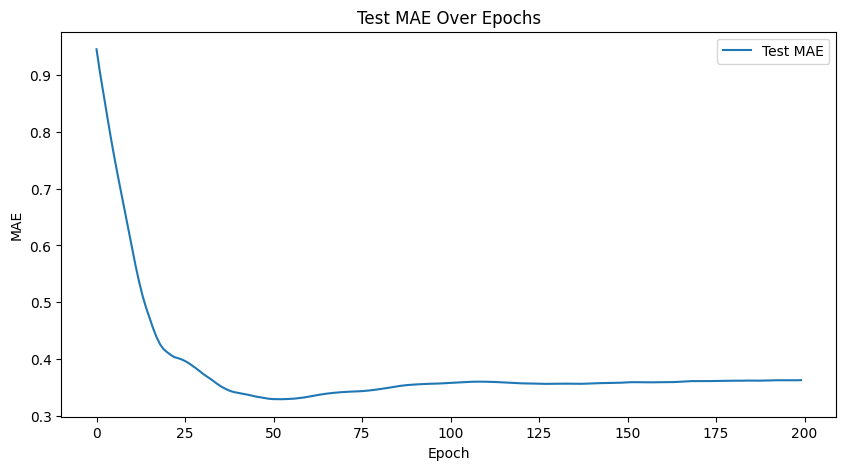

Final Test MSE: 0.25760963559150696
Final Test R-squared: 0.6848249435424805
Final Test MAE: 0.3625452220439911


In [7]:
train_losses = []
test_losses = []
r2_losses = []
mae_losses = []


for epoch in range(200):
    model.train()
    optimizer.zero_grad()
    out = model(data_train)
    train_loss = criterion(out, y_train)
    train_loss.backward()
    optimizer.step()
    
    model.eval()  
    with torch.no_grad(): # gradient is not computed
        test_pred = model(data_test)
        test_loss = criterion(test_pred, y_test)
        r2 = util.r_squared(y_test, test_pred) 
        mae_loss = mae_criterion(test_pred, y_test)

    
    train_losses.append(train_loss.item())
    test_losses.append(test_loss.item())
    r2_losses.append(r2.item())
    mae_losses.append(mae_loss.item())

# training and testing losses
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Test Loss Over Epochs')
plt.legend()
plt.show()

# Plot R-squared values
plt.figure(figsize=(10, 5))
plt.plot(r2_losses, label='Test R-squared')
plt.xlabel('Epoch')
plt.ylabel('R-squared')
plt.title('Test R-squared Over Epochs')
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(mae_losses, label='Test MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.title('Test MAE Over Epochs')
plt.legend()
plt.show()

model.eval() 
with torch.no_grad(): 
    final_pred = model(data_test)
    final_mse_test = criterion(final_pred, y_test)
    final_r2_test = util.r_squared(y_test, final_pred)
    final_mae_test = mae_criterion(final_pred, y_test)

print(f'Final Test MSE: {final_mse_test.item()}')
print(f'Final Test R-squared: {final_r2_test.item()}')
print(f'Final Test MAE: {final_mae_test.item()}')

In [8]:
df = pd.read_csv('../../Datasets/study_373/top_5_373_time.csv', usecols=['46670', '46982', '46504', '46571', '46888'])
"""
46670  [Nyctereutes procyonoides]     Common Raccoon Dog      -> Rodents, Japanese Hare
46982  [Sus scrofa]				      Wild Boar               -> Rodents, Japanese Hare
46504  [Lepus brachyurus]			  Japanese Hare
46571  [Meles anakuma]			      Japanese Badger         -> Rodents
46888  [Rodentia]
"""

for col in ['46670', '46982', '46504', '46571', '46888']:
    df[f'{col}_lag1'] = df[col].shift(1)
df.dropna(inplace=True)

# Define features (x) and targets (y)
x = df[['46670_lag1', '46982_lag1', '46504_lag1', '46571_lag1', '46888_lag1']].values  # previous time step's data as input
y = df[['46670', '46982', '46504', '46571', '46888']].values  
print(df)

         46670     46982  46504  46571  46888  46670_lag1  46982_lag1  \
1     1.000000  2.030303    1.0    1.0    2.0    1.000000    2.000000   
2     1.000000  2.060606    1.0    1.0    2.0    1.000000    2.030303   
3     1.000000  2.090909    1.0    1.0    2.0    1.000000    2.060606   
4     1.000000  2.121212    1.0    1.0    2.0    1.000000    2.090909   
5     1.000000  2.151515    1.0    1.0    2.0    1.000000    2.121212   
...        ...       ...    ...    ...    ...         ...         ...   
1611  2.272727  5.363636    1.0    1.0    2.0    2.363636    4.818182   
1612  2.181818  5.909091    1.0    1.0    2.0    2.272727    5.363636   
1613  2.090909  6.454545    1.0    1.0    2.0    2.181818    5.909091   
1614  2.000000  7.000000    1.0    1.0    2.0    2.090909    6.454545   
1615  2.000000  1.000000    1.0    1.0    1.0    2.000000    7.000000   

      46504_lag1  46571_lag1  46888_lag1  
1            1.0         1.0         2.0  
2            1.0         1.0         

In [9]:
# Sequential split for training and testing
split_idx = int(len(x) * 0.8)
x_train, x_test = x[:split_idx], x[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]

scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

scaler = StandardScaler()
y_train = scaler.fit_transform(y_train)
y_test = scaler.transform(y_test)

# Convert to PyTorch tensors
x_train = torch.tensor(x_train, dtype=torch.float)
x_test = torch.tensor(x_test, dtype=torch.float)
y_train = torch.tensor(y_train, dtype=torch.float)
y_test = torch.tensor(y_test, dtype=torch.float)

In [10]:
edge_index = torch.tensor([
    [0, 0, 3, 3, 4],  # Predators: 46670 (Index 0), 46982 (Index 3), 46571 (Index 4)
    [1, 2, 1, 2, 1]   # Prey: 46888 (Index 1), 46504 (Index 2)
], dtype=torch.long)
data_train = Data(x=x_train, edge_index=edge_index)
data_test = Data(x=x_test, edge_index=edge_index)

In [11]:
# Model Implementation
class GNN(torch.nn.Module):
    def __init__(self):
        super(GNN, self).__init__()
        self.conv1 = GCNConv(5, 16)
        self.conv2 = GCNConv(16, 5)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = torch.relu(self.conv1(x, edge_index))
        x = self.conv2(x, edge_index)
        return x

In [12]:
model = GNN()
optimizer = Adam(model.parameters(), lr=0.01)
criterion = MSELoss()
mae_criterion = L1Loss()

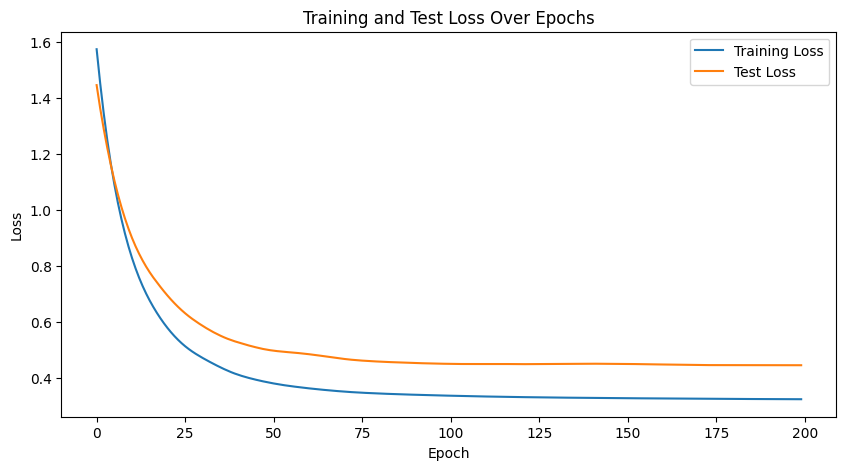

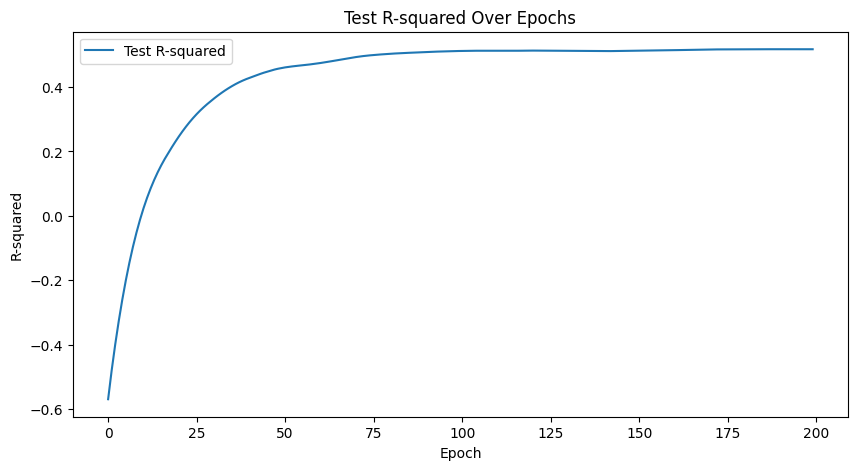

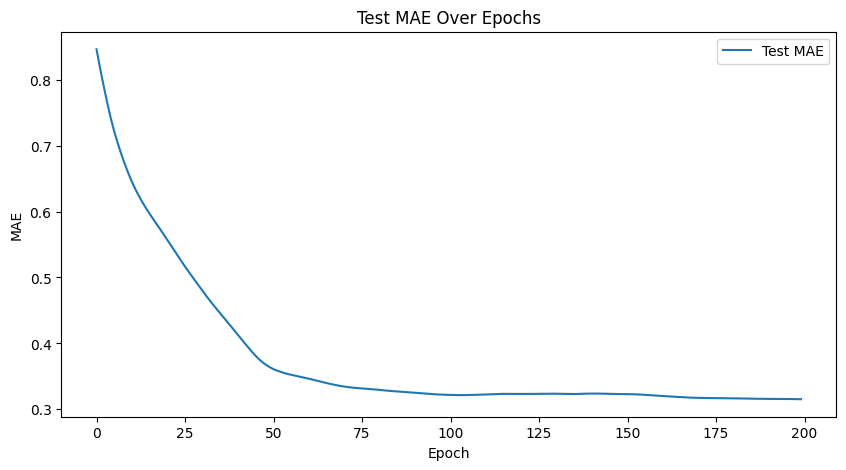

Final Test MSE: 0.4443412721157074
Final Test R-squared: 0.5175281763076782
Final Test MAE: 0.315323144197464


In [13]:
train_losses = []
test_losses = []
r2_losses = []
mae_losses = []


for epoch in range(200):
    model.train()
    optimizer.zero_grad()
    out = model(data_train)
    train_loss = criterion(out, y_train)
    train_loss.backward()
    optimizer.step()
    
    model.eval()  
    with torch.no_grad(): # gradient is not computed
        test_pred = model(data_test)
        test_loss = criterion(test_pred, y_test)
        r2 = util.r_squared(y_test, test_pred) 
        mae_loss = mae_criterion(test_pred, y_test)

    
    train_losses.append(train_loss.item())
    test_losses.append(test_loss.item())
    r2_losses.append(r2.item())
    mae_losses.append(mae_loss.item())

# training and testing losses
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Test Loss Over Epochs')
plt.legend()
plt.show()

# Plot R-squared values
plt.figure(figsize=(10, 5))
plt.plot(r2_losses, label='Test R-squared')
plt.xlabel('Epoch')
plt.ylabel('R-squared')
plt.title('Test R-squared Over Epochs')
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(mae_losses, label='Test MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.title('Test MAE Over Epochs')
plt.legend()
plt.show()

model.eval() 
with torch.no_grad(): 
    final_pred = model(data_test)
    final_mse_test = criterion(final_pred, y_test)
    final_r2_test = util.r_squared(y_test, final_pred)
    final_mae_test = mae_criterion(final_pred, y_test)

print(f'Final Test MSE: {final_mse_test.item()}')
print(f'Final Test R-squared: {final_r2_test.item()}')
print(f'Final Test MAE: {final_mae_test.item()}')

In [14]:
df = pd.read_csv('../../Datasets/study_213/top_5_213_time.csv', usecols=['7058', '8572', '39601', '8901', '7730'])
"""
7058 ['Merluccius bilinearis']  Silver hake             -> Silver hake, Spiny dogfish, Longfin inshore squid, Red hake, American butterfish
8572 ['Squalus acanthias']      Spiny dogfish           -> Silver hake, Spiny dogfish, Longfin inshore squid, Red hake, American butterfish
39601 ['Doryteuthis pealeii']   Longfin inshore squid   -> Silver hake, Longfin inshore squid
8901 ['Urophycis chuss']        Red hake                -> Silver hake, Longfin inshore squid, Red hake, American butterfish
7730 ['Peprilus triacanthus']   American butterfish     -> Longfin inshore squid
"""

for col in ['7058', '8572', '39601', '8901', '7730']:
    df[f'{col}_lag1'] = df[col].shift(1)
df.dropna(inplace=True)

# Define features (x) and targets (y)
x = df[['7058_lag1', '8572_lag1', '39601_lag1', '8901_lag1', '7730_lag1']].values  # previous time step's data as input
y = df[['7058', '8572', '39601', '8901', '7730']].values  
print(df)

              7058        8572       39601        8901       7730  \
1      1488.923077  409.384615   18.923077  161.423077   1.961538   
2      1446.846154  396.769231   18.846154  158.846154   1.923077   
3      1404.769231  384.153846   18.769231  156.269231   1.884615   
4      1362.692308  371.538462   18.692308  153.692308   1.846154   
5      1320.615385  358.923077   18.615385  151.115385   1.807692   
...            ...         ...         ...         ...        ...   
16427   732.000000  468.000000   32.000000  186.000000   1.000000   
16428   568.500000  351.750000  141.750000  139.750000   4.250000   
16429   405.000000  235.500000  251.500000   93.500000   7.500000   
16430   241.500000  119.250000  361.250000   47.250000  10.750000   
16431    78.000000    3.000000  471.000000    1.000000  14.000000   

         7058_lag1   8572_lag1  39601_lag1   8901_lag1  7730_lag1  
1      1531.000000  422.000000   19.000000  164.000000   2.000000  
2      1488.923077  409.384615   18

In [15]:
# Sequential split for training and testing
split_idx = int(len(x) * 0.8)
x_train, x_test = x[:split_idx], x[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]

scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

scaler = StandardScaler()
y_train = scaler.fit_transform(y_train)
y_test = scaler.transform(y_test)

# Convert to PyTorch tensors
x_train = torch.tensor(x_train, dtype=torch.float)
x_test = torch.tensor(x_test, dtype=torch.float)
y_train = torch.tensor(y_train, dtype=torch.float)
y_test = torch.tensor(y_test, dtype=torch.float)

In [16]:
edge_index = torch.tensor([
    [0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 2, 2, 3, 3, 3, 3, 4],  
    [0, 1, 2, 3, 4, 0, 1, 2, 3, 4, 0, 2, 0, 2, 3, 4, 2]   
], dtype=torch.long)
data_train = Data(x=x_train, edge_index=edge_index)
data_test = Data(x=x_test, edge_index=edge_index)

In [17]:
# Model Implementation
class GNN(torch.nn.Module):
    def __init__(self):
        super(GNN, self).__init__()
        self.conv1 = GCNConv(5, 16)
        self.conv2 = GCNConv(16, 5)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = torch.relu(self.conv1(x, edge_index))
        x = self.conv2(x, edge_index)
        return x

In [18]:
model = GNN()
optimizer = Adam(model.parameters(), lr=0.01)
criterion = MSELoss()
criterion_mae = L1Loss()

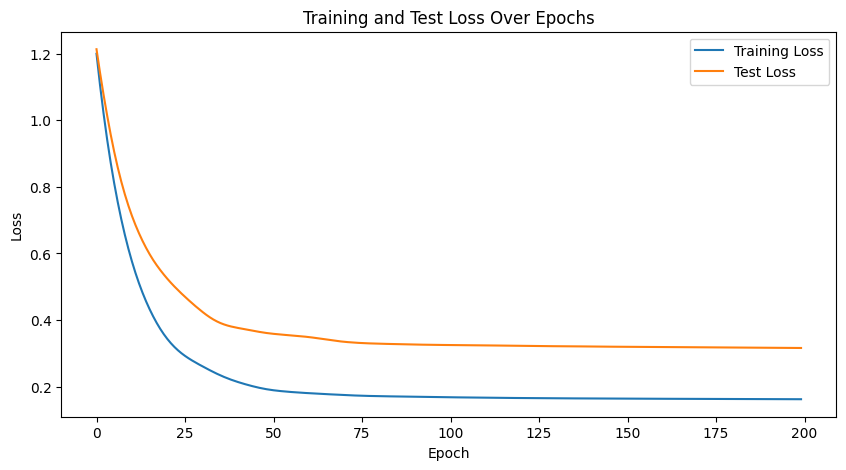

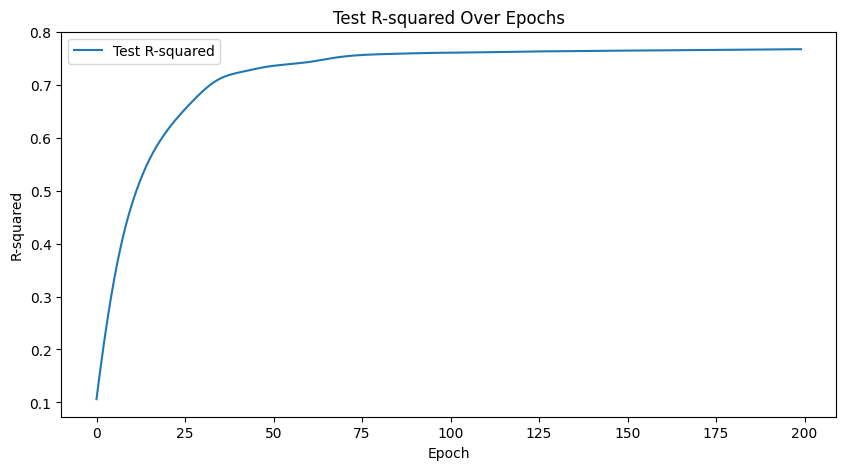

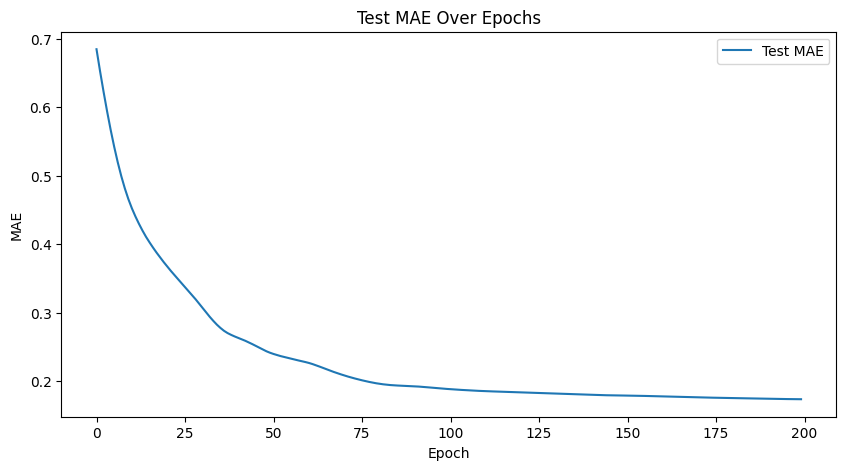

Final Test MSE: 0.316089004278183
Final Test R-squared: 0.7671994566917419
Final Test MAE: 0.17350497841835022


In [19]:
train_losses = []
test_losses = []
r2_losses = []
mae_losses = []


for epoch in range(200):
    model.train()
    optimizer.zero_grad()
    out = model(data_train)
    train_loss = criterion(out, y_train)
    train_loss.backward()
    optimizer.step()
    
    model.eval()  
    with torch.no_grad(): # gradient is not computed
        test_pred = model(data_test)
        test_loss = criterion(test_pred, y_test)
        r2 = util.r_squared(y_test, test_pred) 
        mae_loss = mae_criterion(test_pred, y_test)

    
    train_losses.append(train_loss.item())
    test_losses.append(test_loss.item())
    r2_losses.append(r2.item())
    mae_losses.append(mae_loss.item())

# training and testing losses
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Test Loss Over Epochs')
plt.legend()
plt.show()

# Plot R-squared values
plt.figure(figsize=(10, 5))
plt.plot(r2_losses, label='Test R-squared')
plt.xlabel('Epoch')
plt.ylabel('R-squared')
plt.title('Test R-squared Over Epochs')
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(mae_losses, label='Test MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.title('Test MAE Over Epochs')
plt.legend()
plt.show()

model.eval() 
with torch.no_grad(): 
    final_pred = model(data_test)
    final_mse_test = criterion(final_pred, y_test)
    final_r2_test = util.r_squared(y_test, final_pred)
    final_mae_test = mae_criterion(final_pred, y_test)

print(f'Final Test MSE: {final_mse_test.item()}')
print(f'Final Test R-squared: {final_r2_test.item()}')
print(f'Final Test MAE: {final_mae_test.item()}')